# Units, coordiante system and parameter definitions in lenstronomy

This notebook goes into some detail in the definition of units used in the parameters and coordinate system. This notebook supplements the starting guide and goes a bit deeper in certain aspects, usefull for beginners as well as advanced usage.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lenstronomy.Plots import lens_plot
from lenstronomy.Plots import plot_util

from lenstronomy.Data.pixel_grid import PixelGrid
import lenstronomy.Util.param_util as param_util
from lenstronomy.Util import util
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LensModel.lens_model import LensModel

## Units in lenstronomy

The philosophy of lenstronomy is to describe data in a parameterized form. Thus the primary units used in lenstronomy are angles on the sky and for the lensing operators the mapping between the image to the source plane anlge (reduced deflection anlge).
Physical units that require an absolute scale/distance to be assumed are avoided in lenstronomy whenever possible. E.g. a relative Fermat potential has units angle^2 and only when computing the time delay, lenstronomy needs a cosmology assumption and assumes the angles to be in units of arcseconds^2. We recommend the user to use relative arcseconds as their units of choice but any other scale can be used provided the conversion to physical units are changed.


## Coordinate system definitions
lenstronomy operates on a coordinate system and does not use the pixel units as a basis. Instead, lenstronomy requires a zero point and a linear mapping matrix between the shift of one pixel in units of the two angles on the sky. This allows simultaneous simulation/modelling of shifted or rotated exposures as well as data with different pixel scales.

The user can specify this coordinate system arbitrarly (it does not necessarily be the equitorial coordinate system where RA is E and DEC is N) and model infered quantities are made in reference to the coordinate system of choice.

In a fits header, the quantities CD1_1, CD1_2, CD2_1, CD2_2 are the matrix elements needed. Attention: Be aware of the units and translate them in arcseconds!

In the following, we give two examples of initializing a coordinate grid, first with RA to positive y-axis (N) and DEC to negative x-axis (E) and second from matrix elements of the fits header.


50.0 50.0
0.0 0.0


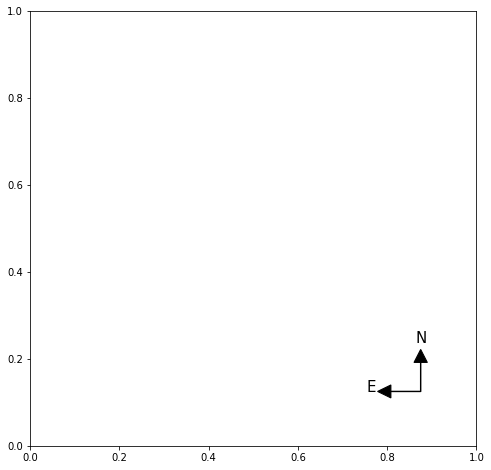

50.0 50.0
0.0 0.0


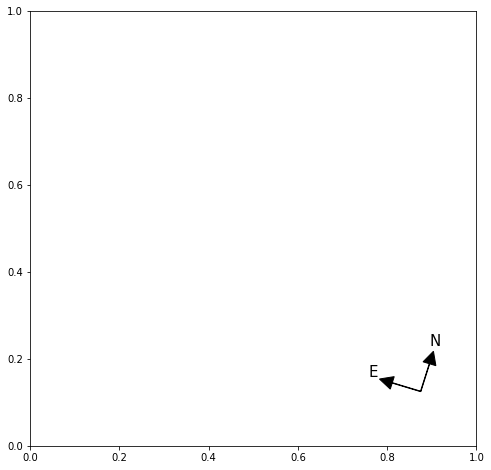

In [2]:

deltaPix = 0.05  # size of pixel in angular coordinates #

# x-axis is going W and y-axis is going N
ra_at_xy_0, dec_at_xy_0 = 2.5, -2.5 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[-deltaPix, 0], [0, deltaPix]])  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': 100, 'ny': 100,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)

x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)
print(x_pos, y_pos)

ra_pos, dec_pos = pixel_grid.map_pix2coord(x=50, y=50)
print(ra_pos, dec_pos)

f, ax = plt.subplots(1, 1, figsize=(8, 8), sharex=False, sharey=False)
plot_util.coordinate_arrows(ax, d=1, coords=pixel_grid, color='k', font_size=15, arrow_size=0.03)
plt.show()


# custom coordinate system with a rotation angle

# in units of degrees as normally defined in fits headers:

psi = 0.3  # rotation angle in North to West in radian
CD1_1 = -deltaPix * np.cos(psi)
CD1_2 = deltaPix * np.sin(psi)
CD2_1 = deltaPix * np.sin(psi)
CD2_2 = deltaPix * np.cos(psi)


transform_pix2angle = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])  # linear translation matrix of a shift in pixel in a shift in coordinates
ra_at_xy_0, dec_at_xy_0 = transform_pix2angle.dot([-50, -50]).T
kwargs_pixel_rot = {'nx': 100, 'ny': 100,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid_rot = PixelGrid(**kwargs_pixel_rot)

x_pos, y_pos = pixel_grid_rot.map_coord2pix(ra=0, dec=0)
print(x_pos, y_pos)

ra_pos, dec_pos = pixel_grid_rot.map_pix2coord(x=50, y=50)
print(ra_pos, dec_pos)

f, ax = plt.subplots(1, 1, figsize=(8, 8), sharex=False, sharey=False)
plot_util.coordinate_arrows(ax, d=1, coords=pixel_grid_rot, color='k', font_size=15, arrow_size=0.03)
plt.show()

## Parameter definitions

Some parameters do have directional information imprinted, and thus depend on the coordinate system applied. In particular, the ellipticity components and light and lens profiles as well as shear components in the lens models are of such nature.

In the following we go through those parameters and relate their definition with respect of a coordinate system with North to top and East to the left.



### Ellipticity definition for light and lens models

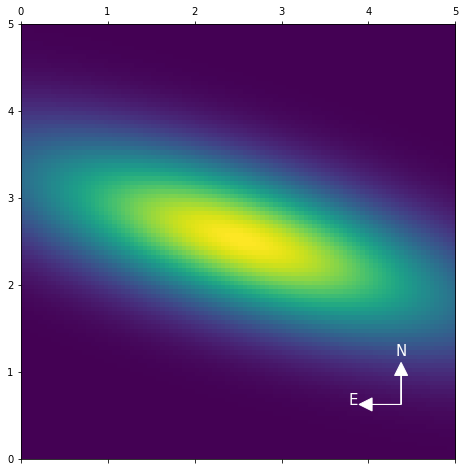

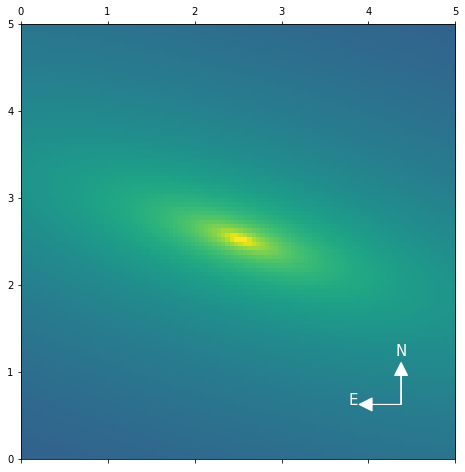

In [3]:
# we get the coordinates for each pixel of the grid defined above
x_grid, y_grid = pixel_grid.pixel_coordinates

frame_size = deltaPix * len(x_grid)

# axis ratio (minor/major axis)
q = 0.3
# angle of major axis (radian)
phi = 0.3  # major axis direction from E to N
e1, e2 = param_util.phi_q2_ellipticity(phi=phi, q=q)
# inverse transformation for completeness (redundant)
phi, q = param_util.ellipticity2phi_q(e1, e2)

# here we model an elliptical Gaussian light profile
light = LightModel(light_model_list=['GAUSSIAN_ELLIPSE'])
kwargs_light = [{'amp': 1, 'sigma': 1, 'e1': e1, 'e2': e2, 'center_x': 0, 'center_y': 0}]
flux = light.surface_brightness(x_grid, y_grid, kwargs_light)
f, ax = plt.subplots(1, 1, figsize=(8, 8), sharex=False, sharey=False)
ax.matshow(flux, origin='lower', extent=[0, frame_size, 0, frame_size])
plot_util.coordinate_arrows(ax, d=frame_size, coords=pixel_grid, color='w', font_size=15, arrow_size=0.03)
plt.show()



# and here we model the convergence of an isothermal ellipsoid lens profile
lens = LensModel(lens_model_list=['SIE'])
kwargs_lens = [{'theta_E': 1, 'e1': e1, 'e2': e2, 'center_x': 0, 'center_y': 0}]
kappa = lens.kappa(x_grid, y_grid, kwargs_lens)

f, ax = plt.subplots(1, 1, figsize=(8, 8), sharex=False, sharey=False)
ax.matshow(np.log10(kappa), origin='lower', extent=[0, frame_size, 0, frame_size], vmin=-2, vmax=1)
plot_util.coordinate_arrows(ax, d=frame_size, coords=pixel_grid, color='w', font_size=15, arrow_size=0.03)
plt.show()

### Shear definition
The 'SHEAR' model uses the two shear components named 'e1' and 'e2' as input parameters. Lenstronomy provides functionality to turn those into shear strength and direction with its utility functions. There is also a lens model 'SHEAR_GAMMA_PSI' which operates in 'gamma_ext' and 'psi_ext' parameters directly.

To demonstrate the definiton of the shear direction, we simulate a spherical surface brightness profile that is sheared.

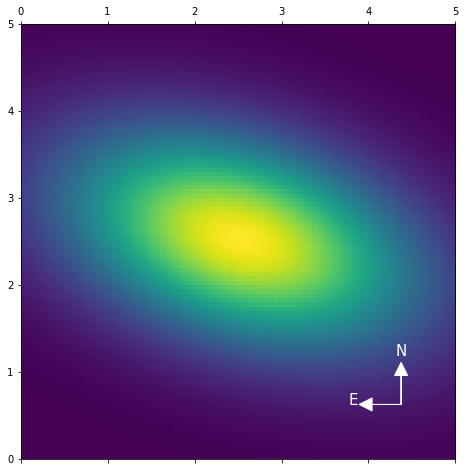

In [4]:
# shear strength
gamma_ext = 0.3
# shear direction
psi_ext = 0.3  # the shear angle is defined in distorting along East to North
# distortion matrix
gamma1, gamma2 = param_util.shear_polar2cartesian(phi=psi_ext, gamma=gamma_ext)
# inverse transform
gamma_ext, psi_ext = param_util.shear_cartesian2polar(gamma1, gamma2)

# we initiate a SHEAR lens model
shear = LensModel(lens_model_list=['SHEAR'])
kwargs_shear = [{'gamma1': gamma1, 'gamma2': gamma2}]
x_sheard, y_sheard = shear.ray_shooting(x_grid, y_grid, kwargs_shear)

# and here we illustrate the shear effect by distorting a spherical Gaussian light distribution on a coordinate grid defined above
kwargs_light_spherical = [{'amp': 1, 'sigma': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
flux = light.surface_brightness(x_sheard, y_sheard, kwargs_light_spherical)

f, ax = plt.subplots(1, 1, figsize=(8, 8), sharex=False, sharey=False)
ax.matshow(flux, origin='lower', extent=[0, frame_size, 0, frame_size])
plot_util.coordinate_arrows(ax, d=frame_size, coords=pixel_grid, color='w', font_size=15, arrow_size=0.03)
plt.show()

### Flux and surface brightness definitions

Light model profile amplitudes are described in units of surface brightness (counts per time per square angle). The 'amp' parameter is the linear scaling parameter. Point source amplitudes are paramterized as counts per time. The $\texttt{SimulationAPI}$ module comes with convenient functionality to define specific light profiles (such as Sersic profiles) in the astronomical magnitude system - provided that the observations are defined with a magnitude zero point.